<a href="https://colab.research.google.com/github/juansala/underactuated_project/blob/main/Reaction_Wheel_Pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome!  If you are new to Google Colab/Jupyter notebooks, you might take a look at [this notebook](https://colab.research.google.com/notebooks/basic_features_overview.ipynb) first.

**I recommend you run the first code cell of this notebook immediately, to start provisioning drake on the cloud machine, then you can leave this window open as you [read the textbook](http://underactuated.csail.mit.edu/intro.html).**

# Notebook Setup

The following cell will:
- on Colab (only), install Drake to `/opt/drake`, install Drake's prerequisites via `apt`, and add pydrake to `sys.path`.  This will take approximately two minutes on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  If you navigate between notebooks using Colab's "File->Open" menu, then you can avoid provisioning a separate machine for each notebook.
- import packages used throughout the notebook.

You will need to rerun this cell if you restart the kernel, but it should be fast (even on Colab) because the machine will already have drake installed.

In [2]:
import importlib
import sys
from urllib.request import urlretrieve

# Install drake (and underactuated).
if 'google.colab' in sys.modules and importlib.util.find_spec('underactuated') is None:
    urlretrieve(f"http://underactuated.csail.mit.edu/scripts/setup/setup_underactuated_colab.py",
                "setup_underactuated_colab.py")
    from setup_underactuated_colab import setup_underactuated
    setup_underactuated(underactuated_sha='ffe2b28ed89637889c04405e5d7d2d98be3df5b6', drake_version='0.25.0', drake_build='releases')

server_args = []
if 'google.colab' in sys.modules:
  server_args = ['--ngrok_http_tunnel']
# Start two meshcat server instances to use for the remainder of this notebook.
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc_planar, zmq_url_planar, web_url_planar = start_zmq_server_as_subprocess(server_args=server_args)
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=server_args)


# Imports.
import matplotlib.pyplot as plt
import numpy as np
import pydrake.all

from pydrake.all import (Jacobian, MathematicalProgram, Solve, Polynomial, AddMultibodyPlantSceneGraph, PlanarSceneGraphVisualizer, Parser, LinearQuadraticRegulator, Simulator, VectorSystem, Saturation, SignalLogger, wrap_to, RealContinuousLyapunovEquation, Variable, Variables)
from pydrake.examples.pendulum import PendulumGeometry, PendulumPlant

import underactuated
from underactuated.jupyter import AdvanceToAndVisualize, SetupMatplotlibBackend
from underactuated.jupyter import running_as_notebook

Cloning into '/opt/underactuated'...

HEAD is now at ffe2b28 update shas






In [3]:
# For some mysterious reason, this needs to be run in a second cell for the change to persist.
plt_is_interactive = SetupMatplotlibBackend(['notebook']) # Use 'inline' to force non-interactive.

# Dynamics of the Reaction Wheel Pendulum

Below are the dynamics parameters of the reaction wheel pendulum, followed by the corresponding URDF string.


In [5]:
m = 2 # total mass of wheel and link 
m_r = 1 # mass of the wheel
m_L = 1 # mass of the link 
I_r = 0.2 # MOI of the reaction wheel about its COM
I_L = 0.1 # MOI of link about its COM
l_r = 1 # distance from pivot to wheel COM
l_L = 0.5 # distance from pivot to link COM
I_total = I_r + m_r*l_r**2 + I_L + m_L*l_L**2 # total MOI of the reaction wheel pendulum about the pivot
m_bar = m_r*l_r + m_L*l_L

l = 1 # distance from the pivot to the COM
g = 9.81 # gravitational constant
b_r = 0.1 # reaction wheel damping factor, NOT USED
b_L = 0.1 # link damping factor, NOT USED

u_max = 10 # maximum allowed input torque

In [6]:
rxpend_urdf = """

<?xml version="1.0"?>

<robot xmlns="http://drake.mit.edu"
 xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
 xsi:schemaLocation="http://drake.mit.edu ../../doc/drakeURDF.xsd" name="Reaction Wheel Pendulum">
  <material name="black">
    <color rgba="0 0 0 1" />
  </material>
  <material name="MITred">
    <color rgba=".6 .2 .2 1" />
  </material>

  <link name="base">
    <inertial>
      <origin xyz="0 0 0" />
      <mass value="0.01" />
      <inertia ixx="0" ixy="0" ixz="0" iyy="0" iyz="0" izz="0" />
    </inertial>
  </link>
  <joint name="base_weld" type="fixed">
    <parent link="world" />
    <child link="base" />
  </joint>

  <link name="upper_arm">
    <inertial> 
      <origin xyz="0 0 -1" rpy="0 0 0" />
      <mass value="1" />
      <inertia ixx="0.1" ixy="0" ixz="0" iyy="0.1" iyz="0" izz="0"/> 
    </inertial>
    <visual>
      <origin xyz="0 0 -.5" rpy="0 0 0" />
      <geometry>
         <cylinder length="1" radius=".01" />
      </geometry>
      <material name="black" />
    </visual> 
  </link>
  <joint name="shoulder" type="continuous">
    <parent link="base"/>
    <child link="upper_arm" />
    <axis xyz="0 1 0" />
    <dynamics damping="0.0" />
  </joint>

  <link name="wheel">
    <inertial> 
      <origin xyz="0 0 0" rpy="0 0 0" />
      <mass value="1" />
      <inertia ixx="0.2" ixy="0" ixz="0" iyy="0.2" iyz="0" izz="0"/> 
    </inertial>
    <visual>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <geometry>
         <sphere radius=".5" />
      </geometry>
      <material name="MITred" />
    </visual> 
    <visual>
      <origin xyz="0 0 -0.25"/>
      <geometry>
        <sphere radius=".05"/>
      </geometry>
      <material name="black" />
    </visual>

  </link>
  <joint name="elbow" type="continuous">
    <parent link="upper_arm"/>
    <origin xyz="0 0 -1" />
    <child link="wheel" />
    <axis xyz="0 1 0" />
    <dynamics damping="0.0" />
  </joint>
  <transmission type="SimpleTransmission" name="elbow_trans">
    <actuator name="elbow" />
    <joint name="elbow" />
    <mechanicalReduction>1</mechanicalReduction>
  </transmission>

</robot> """

In [ ]:
# Set up a block diagram with the robot (dynamics) and a visualization block.
builder = pydrake.systems.framework.DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)

# Load the double pendulum from Universal Robot Description Format
parser = pydrake.multibody.parsing.Parser(plant, scene_graph)
# parser.AddModelFromFile(underactuated.FindResource("models/double_pendulum.urdf"))
Parser(plant).AddModelFromString(rxpend_urdf, "urdf")
plant.Finalize()

builder.ExportInput(plant.get_actuation_input_port())
visualizer = builder.AddSystem(PlanarSceneGraphVisualizer(scene_graph,
                                                          xlim=[-2.8, 2.8],
                                                          ylim=[-2.8, 2.8],
                                                          show=plt_is_interactive))
builder.Connect(scene_graph.get_pose_bundle_output_port(),
                visualizer.get_input_port(0))

# The logger needs to be told to expect a 4-element input
# (the 4-element double pendulum state, in this case).
logger = builder.AddSystem(pydrake.systems.primitives.SignalLogger(4))
logger.DeclarePeriodicPublish(0.033333, 0.0)
builder.Connect(plant.get_state_output_port(), logger.get_input_port(0))

diagram = builder.Build()

# Set up a simulator to run this diagram
simulator = pydrake.systems.analysis.Simulator(diagram)

# Set the initial conditions
context = simulator.get_mutable_context()
context.SetContinuousState([0., 0., 0., 0.])  # (theta1, theta2, theta1dot, theta2dot)
diagram.get_input_port(0).FixValue(context, [1.])   # Zero input torques

# Simulate and animate
AdvanceToAndVisualize(simulator, visualizer, 10.0)


simulating...  done.
generating animation...


KeyboardInterrupt: ignored

# LQR for the Reaction Wheel Pendulum

I used code from the LQR cart-pole example in acrobot.py to do a first-pass implementation for the reaction wheel pendulum about the upright state.

In [ ]:
def rxnwheel_balancing_example():
    def UprightState():
        state = (np.pi, 0, 0, 0)
        return state


    def BalancingLQR(plant):
        # Design an LQR controller for stabilizing the CartPole around the upright.
        # Returns a (static) AffineSystem that implements the controller (in
        # the original CartPole coordinates).

        context = plant.CreateDefaultContext()
        plant.get_actuation_input_port().FixValue(context, [0])

        context.get_mutable_continuous_state_vector().SetFromVector(UprightState())

        Q = np.diag((1, 1., 1., 1.))
        R = [10]

        # MultibodyPlant has many (optional) input ports, so we must pass the
        # input_port_index to LQR.
        lqr = LinearQuadraticRegulator(
            plant,
            context,
            Q,
            R,
            input_port_index=plant.get_actuation_input_port().get_index())
        return lqr


    builder = pydrake.systems.framework.DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    Parser(plant).AddModelFromString(rxpend_urdf, "urdf")
    plant.Finalize()

    controller = builder.AddSystem(BalancingLQR(plant))

    saturation = builder.AddSystem(Saturation(min_value=[-u_max], max_value=[u_max]))
    builder.Connect(saturation.get_output_port(0), plant.get_actuation_input_port())
    builder.Connect(plant.get_state_output_port(), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))

    # builder.Connect(plant.get_state_output_port(), controller.get_input_port(0))
    # builder.Connect(controller.get_output_port(0),
    #                 plant.get_actuation_input_port())

    # Setup visualization
    visualizer = pydrake.systems.meshcat_visualizer.ConnectMeshcatVisualizer(
        builder, 
        scene_graph=scene_graph, 
        zmq_url=zmq_url_planar)
    visualizer.vis.delete()
    visualizer.set_planar_viewpoint(xmin=-2.5, xmax=2.5, ymin=-1.0, ymax=2.5)

    diagram = builder.Build()

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    simulator.set_target_realtime_rate(1.0)
    context = simulator.get_mutable_context()

    # Simulate
    duration = 15.0 if running_as_notebook else 0.1 # sets a shorter duration during testing
    for i in range(5):
        context.SetTime(0.)
        # context.SetContinuousState((np.pi,0,0,0))
        context.SetContinuousState(UprightState() + 0.1 * np.random.randn(4,))
        # context.SetContinuousState(np.random.randn(4,))
        simulator.Initialize()
        simulator.AdvanceTo(duration)

rxnwheel_balancing_example()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6003...
You can open the visualizer by visiting the following URL:
http://583e975035bc.ngrok.io/static/
Connected to meshcat-server.


KeyboardInterrupt: ignored

# Hand-derived pass energy-shaping controller

After deriving an energy shaping swing-up controller on paper, we can implement it to see its performance. This code is mostly borrowed from the simple pendulum energy shaping example, but with the controller modified. In addition to my hand-derived controller, I also tried plugging in Spong's controller to see the results. You can find my derivation in the report. 

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://aa83b81f08f4.ngrok.io/static/
Connected to meshcat-server.


KeyboardInterrupt: ignored

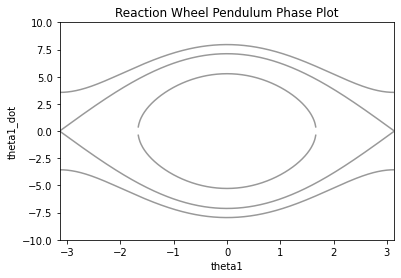

In [7]:
class EnergyShapingController(VectorSystem):

    def __init__(self, pendulum):
        VectorSystem.__init__(self, 4, 1)
        self.pendulum = pendulum
        self.pendulum_context = pendulum.CreateDefaultContext()
        self.pendulum_context.SetContinuousState([np.pi, 0, 0, 0])
        self.desired_energy = self.pendulum.EvalPotentialEnergy(self.pendulum_context)
        # print(self.desired_energy)
        # self.SetPendulumParams(PendulumParams())
        
    # def SetPendulumParams(self, params):
    #   self.pendulum_context.get_mutable_numeric_parameter(0).SetFromVector(params.CopyToVector())
    #   self.pendulum_context.SetContinuousState([0, 0, 0, 0])
    #   self.desired_energy = self.pendulum.EvalPotentialEnergy(self.pendulum_context)

    def DoCalcVectorOutput(self, context, pendulum_state, unused, output):
      self.pendulum_context.SetContinuousState(pendulum_state)
      params = self.pendulum_context.get_numeric_parameter(0)
      theta1 = pendulum_state[0]
      theta1_dot = pendulum_state[2]
      theta2_dot = pendulum_state[3]
      kinetic_energy_minus_2 = 1/2*(I_r + m_r*l_r**2)*theta1_dot**2 + 1/2*(I_L + m_L*l_L**2)*theta1_dot**2 
      total_energy = self.pendulum.EvalPotentialEnergy(self.pendulum_context) + self.pendulum.EvalKineticEnergy(self.pendulum_context) 
      k = 0.1
      ke = 2.0 * 50 * 5
      kv = 1.0

      u = I_r*ke*(total_energy - self.desired_energy)*theta1_dot - kv*theta2_dot # Spong's Controller
      # u = -k*(total_energy - self.desired_energy)*theta2_dot + (m_L*l_L + m_r*l_r)*g*np.sin(theta1)/(I_r - I_total)# final swing-up controller derivation!
      # u = (-0.0001*(total_energy - self.desired_energy)*theta1_dot**2 - I_total*theta1_dot)/I_total - 0.01*theta2_dot
      output[:] = u
      # if np.sign(u) == np.sign(theta2_dot):
      #   output[:] = u - 0.9*np.sign(theta2_dot)*min(np.abs(u),1.75*abs(theta2_dot))
      # print(I_r - I_total)
      

def PhasePlot(pendulum):
    phase_plot = plt.figure()
    ax = phase_plot.gca()
    theta_lim = [-np.pi, np.pi]
    ax.set_xlim(theta_lim)
    ax.set_ylim(-10., 10.)
    ax.set_xlabel("theta1")
    ax.set_ylabel("theta1_dot")
    ax.set_title("Reaction Wheel Pendulum Phase Plot")

    theta = np.linspace(theta_lim[0], theta_lim[1], 601)  # 4*k + 1
    thetadot = np.zeros(theta.shape)
    context = pendulum.CreateDefaultContext()
    params = context.get_numeric_parameter(0)
    context.SetContinuousState([np.pi, 0, 0, 0])
    E_upright = pendulum.EvalPotentialEnergy(context)
    E = [E_upright, .1 * E_upright, 1.5 * E_upright]
    for e in E:
        for i in range(theta.size):
            v = ((e + (m_r+m_L) * g * l *
                  np.cos(theta[i])) / (.5 * I_total))
            if (v >= 0):
                thetadot[i] = np.sqrt(v)
            else:
                thetadot[i] = float("nan")
        ax.plot(theta, thetadot, color=[.6, .6, .6])
        ax.plot(theta, -thetadot, color=[.6, .6, .6])

    return ax


def UprightState():
        state = (np.pi, 0, 0, 0)
        return state

def InitialState():
        state = (0, 0, 0, 0)
        return state

builder = pydrake.systems.framework.DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
Parser(plant).AddModelFromString(rxpend_urdf, "urdf")
plant.Finalize()

ax = PhasePlot(plant)

controller = builder.AddSystem(EnergyShapingController(plant))

saturation = builder.AddSystem(Saturation(min_value=[-u_max], max_value=[u_max]))
builder.Connect(saturation.get_output_port(0), plant.get_actuation_input_port())
builder.Connect(plant.get_state_output_port(), controller.get_input_port(0))
builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))

# No Saturation 
# builder.Connect(controller.get_output_port(), plant.get_actuation_input_port())
# builder.Connect(plant.get_state_output_port(), controller.get_input_port(0))

# Setup visualization
visualizer = pydrake.systems.meshcat_visualizer.ConnectMeshcatVisualizer(
    builder, 
    scene_graph=scene_graph, 
    zmq_url=zmq_url_planar)
visualizer.vis.delete()
visualizer.set_planar_viewpoint(xmin=-2.5, xmax=2.5, ymin=-1.0, ymax=2.5)

logger = builder.AddSystem(SignalLogger(4))
builder.Connect(plant.get_state_output_port(), logger.get_input_port(0))

diagram = builder.Build()

# Set up a simulator to run this diagram
simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1.0)
context = simulator.get_mutable_context()

# Simulate
duration = 30 if running_as_notebook else 0.1 # sets a shorter duration during testing
for i in range(1):
    context.SetTime(0.)
    context.SetContinuousState((0.0, 0, 0, 0))
    simulator.Initialize()
    logger.reset()
    simulator.AdvanceTo(duration)
    # print(logger.data())
    ax.plot(logger.data()[0, :], logger.data()[2, :])

# Swing-up + LQR
We can now combine the swing-up controller with the LQR controller to get a full balancing algorithm. For the ROA, it is currently an educated estimate. We will soon use SOS optimization to compute it. Most of the following code was borrowed from the 'Swing-up and balance' script in the simple pendulum example.

[[-139.79436392   -1.          -47.28504744   -1.85742779]] [[3.27660501e+03 4.72850474e+01 1.11743786e+03 7.16408427e+01]
 [4.72850474e+01 1.85742779e+00 1.61877185e+01 1.22501900e+00]
 [1.11743786e+03 1.61877185e+01 3.81329417e+02 2.45244189e+01]
 [7.16408427e+01 1.22501900e+00 2.45244189e+01 1.79337570e+00]]
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6003...
You can open the visualizer by visiting the following URL:
http://583e975035bc.ngrok.io/static/
Connected to meshcat-server.


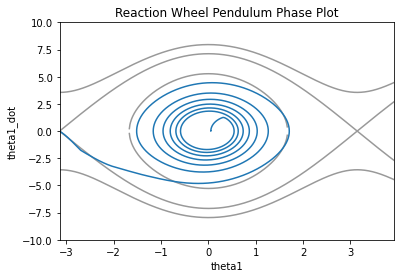

In [ ]:
from pydrake.all import Linearize, LinearQuadraticRegulator
from copy import copy

class SwingUpAndBalanceController(VectorSystem):

    def __init__(self, pendulum, K, S):
        VectorSystem.__init__(self, 4, 1)
        self.energy_shaping = EnergyShapingController(pendulum)
        self.energy_shaping_context = self.energy_shaping.CreateDefaultContext()
        self.K = K
        self.S = S

    def DoCalcVectorOutput(self, context, pendulum_state, unused, output):
        xbar = copy(pendulum_state)
        xbar[0] = wrap_to(xbar[0], 0, 2. * np.pi) - np.pi
        xbar[1] = wrap_to(xbar[1], 0, 2. * np.pi) - np.pi

        # If x'Sx <= 20, then use the LQR controller
        if (xbar.dot(self.S.dot(xbar)) <= 20):
            output[:] = -self.K.dot(xbar)
        else:
            self.get_input_port(0).FixValue(self.energy_shaping_context, pendulum_state)
            output[:] = self.energy_shaping.get_output_port(0).Eval(self.energy_shaping_context)

def UprightState():
    state = (np.pi, 0, 0, 0)
    return state

def InitialState():
        state = (0, 0, 0, 0)
        return state

builder = pydrake.systems.framework.DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
Parser(plant).AddModelFromString(rxpend_urdf, "urdf")
plant.Finalize()
builder.ExportInput(plant.get_actuation_input_port(), "command")

# Linearize plant
diagram = builder.Build()
context = diagram.CreateDefaultContext()
diagram.get_input_port().FixValue(context, [0])
context.SetContinuousState([np.pi, 0, 0, 0])

Q = np.diag((1, 1, 1., 1.))
R = [1]

linearized_pendulum = Linearize(diagram, context)
(K, S) = LinearQuadraticRegulator(linearized_pendulum.A(),
                                      linearized_pendulum.B(), Q, R)
print(K,S)

# Rebuild system

builder = pydrake.systems.framework.DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
Parser(plant).AddModelFromString(rxpend_urdf, "urdf")
plant.Finalize()

def PhasePlot(pendulum):
    phase_plot = plt.figure()
    ax = phase_plot.gca()
    theta_lim = [-np.pi, np.pi + np.pi/4]
    ax.set_xlim(theta_lim)
    ax.set_ylim(-10., 10.)
    ax.set_xlabel("theta1")
    ax.set_ylabel("theta1_dot")
    ax.set_title("Reaction Wheel Pendulum Phase Plot")

    theta = np.linspace(theta_lim[0], theta_lim[1], 601)  # 4*k + 1
    thetadot = np.zeros(theta.shape)
    context = pendulum.CreateDefaultContext()
    params = context.get_numeric_parameter(0)
    context.SetContinuousState([np.pi, 0, 0, 0])
    E_upright = pendulum.EvalPotentialEnergy(context)
    E = [E_upright, .1 * E_upright, 1.5 * E_upright]
    for e in E:
        for i in range(theta.size):
            v = ((e + (m_r+m_L) * g * l *
                  np.cos(theta[i])) / (.5 * I_total))
            if (v >= 0):
                thetadot[i] = np.sqrt(v)
            else:
                thetadot[i] = float("nan")
        ax.plot(theta, thetadot, color=[.6, .6, .6])
        ax.plot(theta, -thetadot, color=[.6, .6, .6])

    return ax
ax = PhasePlot(plant)

swingAndLQR = SwingUpAndBalanceController(plant, K, S)

controller = builder.AddSystem(swingAndLQR)

saturation = builder.AddSystem(Saturation(min_value=[-u_max], max_value=[u_max]))
builder.Connect(saturation.get_output_port(0), plant.get_actuation_input_port())
builder.Connect(plant.get_state_output_port(), controller.get_input_port(0))
builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))

# No Saturation 
# builder.Connect(controller.get_output_port(0), plant.get_actuation_input_port())
# builder.Connect(plant.get_state_output_port(), controller.get_input_port(0))


logger = builder.AddSystem(SignalLogger(4))
builder.Connect(plant.get_state_output_port(), logger.get_input_port(0))

# Setup visualization
visualizer = pydrake.systems.meshcat_visualizer.ConnectMeshcatVisualizer(
    builder, 
    scene_graph=scene_graph, 
    zmq_url=zmq_url_planar)
visualizer.vis.delete()
visualizer.set_planar_viewpoint(xmin=-2.5, xmax=2.5, ymin=-1.0, ymax=2.5)

diagram = builder.Build()
simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1.0)
context = simulator.get_mutable_context()

for i in range(1):
    context.SetTime(0.)
    simulator.Initialize()
    logger.reset()
    context.SetContinuousState((0.05, 0, 0, 0))
    simulator.AdvanceTo(30)
    ax.plot(logger.data()[0, :], logger.data()[2, :])
    
# ax.set_xlim(np.pi - 3., np.pi + 3.)
# ax.set_ylim(-5., 5.)


#Computing a ROA via Linearization, Lyapunov Equation and S-procedure
Here we attempt to compute a Lyapunov function using the Lyapunov Equation. In this formulation, we first linearize the reaction wheel dynamics directly from the MultiBodyPlant then write out the closed-loop dynamics in the form:

$$\dot{\mathbf{x}} = (A-BK){\mathbf{x}}$$

where A and B come from the linearization and K is the LQR gain matrix. Once we have the closed-loop dynamics we can solve the Lyapunov Equation to find P, which defines the candidate Lyapunov function as follows:

$$V(\mathbf{x}) = \mathbf{x}^T P \mathbf{x}$$


In [ ]:
from pydrake.all import Linearize, LinearQuadraticRegulator

builder = pydrake.systems.framework.DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
Parser(plant).AddModelFromString(rxpend_urdf, "urdf")
plant.Finalize()
builder.ExportInput(plant.get_actuation_input_port(), "command")

# Linearize plant about the upright state
diagram = builder.Build()
context = diagram.CreateDefaultContext()
diagram.get_input_port().FixValue(context, [0])
context.SetContinuousState([np.pi, 0, 0, 0])

Q = np.diag((1, 1, 1., 1.))
R = [1]

linearized_pendulum = Linearize(diagram, context)
A = linearized_pendulum.A()
B = linearized_pendulum.B()
# A = np.array([[0,0,1,0], [0,0,0,1], [m*g*l/I_total * np.cos(np.pi), 0, 0, 0], [0, 0, 0, 0]])
# B = np.array([[0], [0], [-1/I_total], [1/I_total]])

# A_test = np.array([[0,0,1], [0,0,0], [m*g*l/I_total * np.cos(np.pi), 0, 0]])

print("A = ", A)
print("B = ", B)
(K, S) = LinearQuadraticRegulator(A, B, Q, R)
print("K = ", K)
print("S = ", S)

# Linearize again, but now with close-loop?

A =  [[ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]
 [ 9.34285714  0.          0.          0.        ]
 [-9.34285714  0.          0.          0.        ]]
B =  [[ 0.        ]
 [ 0.        ]
 [-0.47619048]
 [ 5.47619048]]
K =  [[-139.79436392   -1.          -47.28504744   -1.85742779]]
S =  [[3.27660501e+03 4.72850474e+01 1.11743786e+03 7.16408427e+01]
 [4.72850474e+01 1.85742779e+00 1.61877185e+01 1.22501900e+00]
 [1.11743786e+03 1.61877185e+01 3.81329417e+02 2.45244189e+01]
 [7.16408427e+01 1.22501900e+00 2.45244189e+01 1.79337570e+00]]


In [ ]:
# Define state variables for symbolic expression
x0 = Variable('x0')
x1 = Variable('x1')
x2 = Variable('x2')
x3 = Variable('x3')
state = np.array([[x0], [x1], [x2], [x3]])

# Closed-loop system matrix
A_cl = A-B.dot(K)
print("A_cl = ", A_cl)
print()

# rhs of the Lyapunov equation (standard choice)
Q = np.eye(4)
# Q = np.array([[1,1,1,1], [1,1,1,1], [1,1,1,1], [1,1,1,1]])

# positive definite matrix of the Lyapunov function
P = RealContinuousLyapunovEquation(A_cl, Q)

print("Results from Lyapunov Equation: ")
print("P = ", P)
# print("V_P = ", state.T.dot(P).dot(state))
print()

print("Results from LQR Cost-to-go: ")
print("S = ", S)
# print("V_S = ", state.T.dot(S).dot(state))
print()

# print("RHS of Linearized Dynamics:")
# A = np.array([[0,0,1,0], [0,0,0,1], [-19.62, 0, 0, 0], [0, 0, 0, 0]])
# print("x_dot = ", A_cl.dot(state))

A_cl =  [[ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [-5.72258876e+01 -4.76190476e-01 -2.25166893e+01 -8.84489424e-01]
 [ 7.56197707e+02  5.47619048e+00  2.58941926e+02  1.01716284e+01]]

Results from Lyapunov Equation: 
P =  [[2.14457222e+03 3.91654072e+01 7.33500281e+02 5.55075799e+01]
 [3.91654072e+01 1.77636135e+00 1.34061052e+01 1.07444393e+00]
 [7.33500281e+02 1.34061052e+01 2.51067419e+02 1.89973360e+01]
 [5.55075799e+01 1.07444393e+00 1.89973360e+01 1.49715446e+00]]

Results from LQR Cost-to-go: 
S =  [[3.27660501e+03 4.72850474e+01 1.11743786e+03 7.16408427e+01]
 [4.72850474e+01 1.85742779e+00 1.61877185e+01 1.22501900e+00]
 [1.11743786e+03 1.61877185e+01 3.81329417e+02 2.45244189e+01]
 [7.16408427e+01 1.22501900e+00 2.45244189e+01 1.79337570e+00]]



# Using S-procedure to estimate the ROA

Here we first package our dynamics parameters into the manipulator equation matrices for later convenience. We will use a Taylor sine approximation in order to implement the closed-loop dynamics. We then formulate the optimization problem using the Lyapunov conditions. This section heavily references 

In [9]:
# intializion of the optimization problem
prog = MathematicalProgram()

# Reduced state of the system as a set of indeterminates
# for the SOS verification
# x[0] = angle of the pendulum relative to np.pi (the fixed point)
# x[1] = velocity of the pendulum
# x[2] = velocity of the wheel
nx = 3
x = prog.NewIndeterminates(nx, 'x')
x_eq = np.array([np.pi, 0., 0.])

# Some of following code portions (taylor approximation and model order reduction) were borrowed from an old 6.832 pset (http://underactuated.csail.mit.edu/Spring2018/set_3/set_3_copy_blank.html)
def sin_taylor_around_pi(t, order):
    '''
    Approximates the sine function around pi using Taylor series.
    '''
    if order < 1:
        raise ValueError('The order of the Taylor expansion must be at least 1.') 
    a = (t - np.pi)
    s = - a
    for i in range(1, int((order+1)/2)):
        a *= -1 * (t-np.pi)**2 / ((2*i) * (2*i+1))
        s -= a
    return s

M = np.array([
    [m_L*l_L**2 + m_r*l_r**2 + I_L + I_r, I_r],
    [I_r, I_r]
])
C = np.array([
    [0, 0],
    [0, 0]
])
B = np.array([
    [0.],
    [1.]
])

order_sine = 20
tauG = np.array([
    -(m_L*l_L + m_r*l_r)*g*sin_taylor_around_pi(x[0]+x_eq[0], order_sine),
    0.
])

# lqr solution
# print(K.shape)
# print(S.shape)
K_reduced_sos = np.reshape(np.delete(K, (1), axis=1),(1,3))
# print(K_reduced_sos)
S_reduced_sos = np.delete(np.delete(S, (1), axis=0), (1), axis=1)
# print(S_reduced_sos)

# Lyapunov equation solution
P_reduced_sos = np.delete(np.delete(P, (1), axis=0), (1), axis=1)

# closed-loop dynamics in the form x_dot = f(x)
xdot = np.concatenate([
    [x[1]],
    np.linalg.inv(M).dot(-C.dot(x[1:3]) + tauG - B.dot(K_reduced_sos).dot(x)),
])

# print(xdot)

# LQR cost-to-go as Lyapunov function
V = x.dot(S_reduced_sos).dot(x)

# time derivative of the Lyapunov function
Vdot = 2*x.dot(S_reduced_sos).dot(xdot)

# for S-procedure
lambda_degree = 4
l = prog.NewSosPolynomial(Variables(x), lambda_degree)[0].ToExpression()

rho = prog.NewContinuousVariables(1, 'rho')[0]

prog.AddSosConstraint(x.dot(x)*(V - rho) - l*Vdot)

prog.AddLinearCost(-rho)

if len(prog.GetAllConstraints()) != 0:

    # solve SOS program
    result = Solve(prog)

    # get maximum rho
    assert result.is_success()
    rho_method = result.GetSolution(rho)

    # print maximum rho
    print(f'Method verified rho = {rho_method}.')




NameError: ignored

#Global Stability of the Free Reaction Wheel Pendulum
Using the change of coordinates to sine, cosine, and theta_dot we can 'search' for a candidate global stability Lyapunov function for the free pendulum. The process is very similar to the example in Simple Pendulum.ipynb, but with the dynamics replaced. Note, I used a damped pendulum model in order to converge on a candidate.

In [ ]:
prog = MathematicalProgram()

# Declare the "indeterminates", x.  These are the variables which define the
# polynomials, but are NOT decision variables in the optimization.  We will
# add constraints below that must hold FOR ALL x.
s1 = prog.NewIndeterminates(1, "s")[0]
c1 = prog.NewIndeterminates(1, "c")[0]
theta1_dot = prog.NewIndeterminates(1, "theta1dot")[0]
# theta2_dot = prog.NewIndeterminates(1, "theta2dot")[0]

# c = prog.NewIndeterminates(1, "c")[0]
# thetadot = prog.NewIndeterminates(1, "thetadot")[0]
# TODO(russt): bind the sugar methods so I can write
#  x = prog.NewIndeterminates(["s", "c", "thetadot"])
# x = np.array([s1, c1, theta1_dot, theta2_dot])
x = np.array([s1, c1, theta1_dot])

# Write out the dynamics in terms of sin(theta), cos(theta), and thetadot
f = [c1*theta1_dot, -s1*theta1_dot, -m_bar*g/(I_total-I_r)*s1 - b_L*theta1_dot]
x0 = np.array([0, 1, 0])

deg_V = 2
V = prog.NewFreePolynomial(Variables(x), deg_V).ToExpression()

eps = 1e-4
constraint1 = prog.AddSosConstraint(V - eps * (x - x0).dot(x - x0))

Vdot = V.Jacobian(x).dot(f)

deg_L = 2
L = prog.NewFreePolynomial(Variables(x), deg_L).ToExpression()

constraint2 = prog.AddSosConstraint(-Vdot - L * (s1**2 + c1**2 - 1) - eps *
                                    (x - x0).dot(x - x0) * s1**2)

# Add V(0) = 0 constraint
constraint3 = prog.AddLinearConstraint(
    V.Substitute({
        s1: 0,
        c1: 1,
        theta1_dot: 0,
    }) == 0)

# Add V(theta=pi) = mgl, just to set the scale.
constraint4 = prog.AddLinearConstraint(
    V.Substitute({
        s1: 1,
        c1: 0,
        theta1_dot: 0,
    }) == (m_r + m_L)*g*l)


result = Solve(prog)
assert result.is_success()

print("V =")
Vsol = Polynomial(result.GetSolution(V))
print(Vsol.RemoveTermsWithSmallCoefficients(1e-6))

V =
9.8128358706789847*1 + 0.90015501273345433*theta1dot(0)^2 + -19.625676671303093*c(0) + 1.3876134990135866e-06*c(0) * theta1dot(0) + 9.8128408088327568*c(0)^2 + -6.4905009056031478e-06*s(0) + 0.13520800398905192*s(0) * theta1dot(0) + 2.9630301202323867e-06*s(0) * c(0) + 9.807170629995877*s(0)^2
